<a href="https://colab.research.google.com/github/anton-brandl/sam-bridges/blob/main/notebooks/20230616_positive_only_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finetune SAM
##  Creating training and eval data
The used data is stored in input_data and was produced by the previous notebook.

In this notebook, I want to get modify SAM in a way that I can finetune it.
Then, after loading sample training data, I want to kick off a finetuning job.

In [1]:
!pip install rasterio geopandas segment-geospatial

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<Axes: >

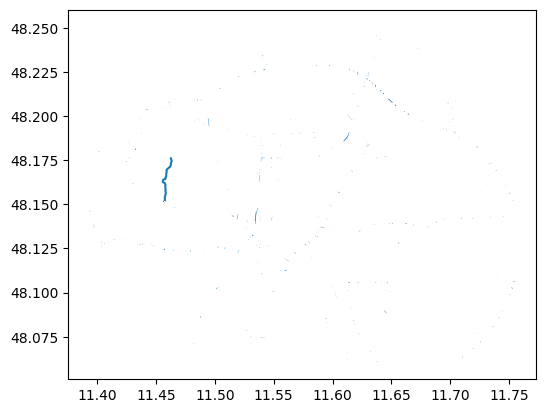

In [3]:

import geopandas as gpd
import matplotlib.pyplot as plt

gdf = gpd.read_file('drive/MyDrive/sam-bridges/input_data/munich_bridges_v3.geojson')

gdf.plot()

In [4]:
# Getting extents of Munich in TMS
bounds_tms = gdf.total_bounds

from samgeo import tms_to_geotiff

image = "drive/MyDrive/sam-bridges/munich_satellite_z16_v3.tif"
tms_to_geotiff(output=image, bbox=list(bounds_tms), zoom=16, source="Satellite", overwrite=True, crs="EPSG:4326")

Downloaded image 0001/3498
Downloaded image 0002/3498
Downloaded image 0003/3498
Downloaded image 0004/3498
Downloaded image 0005/3498
Downloaded image 0006/3498
Downloaded image 0007/3498
Downloaded image 0008/3498
Downloaded image 0009/3498
Downloaded image 0010/3498
Downloaded image 0011/3498
Downloaded image 0012/3498
Downloaded image 0013/3498
Downloaded image 0014/3498
Downloaded image 0015/3498
Downloaded image 0016/3498
Downloaded image 0017/3498
Downloaded image 0018/3498
Downloaded image 0019/3498
Downloaded image 0020/3498
Downloaded image 0021/3498
Downloaded image 0022/3498
Downloaded image 0023/3498
Downloaded image 0024/3498
Downloaded image 0025/3498
Downloaded image 0026/3498
Downloaded image 0027/3498
Downloaded image 0028/3498
Downloaded image 0029/3498
Downloaded image 0030/3498
Downloaded image 0031/3498
Downloaded image 0032/3498
Downloaded image 0033/3498
Downloaded image 0034/3498
Downloaded image 0035/3498
Downloaded image 0036/3498
Downloaded image 0037/3498
D

In [5]:
# Create GeoTiff for Bridge Masks

import geopandas as gpd
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_bounds

# Open the existing GeoTIFF file
raster = rasterio.open(image)

# Rasterize the geometries
geom = [shapes for shapes in gdf.geometry]

rasterized = rasterize(geom,
                    out_shape = raster.shape,
                    fill = 0,
                    out = None,
                    transform = raster.transform,
                    all_touched = False,
                    default_value = 1,
                    dtype = None)
with rasterio.open(
        "drive/MyDrive/sam-bridges/munich_bridge_mask_z16_v3.tif", "w",
        driver = "GTiff",
        crs = raster.crs,
        transform = raster.transform,
        dtype = rasterio.uint8,
        count = 1,
        width = raster.width,
        height = raster.height) as dst:
    dst.write(rasterized, indexes = 1)


### Step 1: Load Satellite imagery and mask and validate (same dimensions)
We also tesselate the tiles by using a windowed data loading

In [7]:
import rasterio
from rasterio.windows import Window
import math
import pandas as pd

TILE_SIZE=256

dataset_dicts = []

# TODO: Extract duplicated code into function

# Open the existing GeoTIFF file
with rasterio.open("drive/MyDrive/sam-bridges/munich_satellite_z16_v3.tif") as fp:
  dims = fp.shape
  num_rows = math.ceil(fp.shape[0]/TILE_SIZE)
  num_cols = math.ceil(fp.shape[1]/TILE_SIZE)
  for row_off in range(num_rows):
    for col_off in range(num_cols):
      # windowed reading of the sub-tile
      w = fp.read(None, window=Window(col_off*TILE_SIZE, row_off*TILE_SIZE, TILE_SIZE, TILE_SIZE))
      w = w.transpose(1,2,0)  # CHW to HWC ordering

      dataset_dicts.append({
          'tile_id': col_off+num_cols*row_off,
          'col_off': col_off,
          'row_off': row_off,
          'type': 'sat',
          'data': w})

with rasterio.open("drive/MyDrive/sam-bridges/munich_bridge_mask_z16_v3.tif") as fp:
  assert dims == fp.shape, "Shapes don't match up"
  num_rows = math.ceil(fp.shape[0]/TILE_SIZE)
  num_cols = math.ceil(fp.shape[1]/TILE_SIZE)
  for row_off in range(num_rows):
    for col_off in range(num_cols):
      # windowed reading of the sub-tile
      w = fp.read(1, window=Window(col_off*TILE_SIZE, row_off*TILE_SIZE, TILE_SIZE, TILE_SIZE))
      dataset_dicts.append({
          'tile_id': col_off+num_cols*row_off,
          'col_off': col_off,
          'row_off': row_off,
          'type': 'mask',
          'data': w})

dataset = pd.DataFrame(dataset_dicts)
assert len(dataset[dataset.type=='mask']) == len(dataset[dataset.type=='sat'])

In [18]:
positive_tile_ids = []
for _, dp in dataset[dataset['type']=='mask'].iterrows():
  if dp['data'].max()>0:
    positive_tile_ids.append(dp['tile_id'])
print(len(positive_tile_ids))
dataset = dataset[dataset['tile_id'].isin(positive_tile_ids)]

369


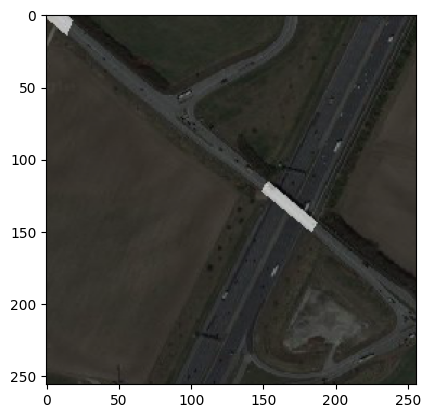

In [25]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np

# Visual check of a sample tile
sample_data_point = dataset[dataset.tile_id == positive_tile_ids[4]]
sample_sat = sample_data_point.query('type=="sat"').iloc[0].data
sample_bridge = sample_data_point.query('type=="mask"').iloc[0].data
plt.imshow((0.5*sample_sat + 0.5*np.stack(3*[sample_bridge*255], axis=-1)).astype(np.uint8))

### Step 2: Assign tiles to train and test datasets


In [30]:
dataset_size = dataset.tile_id.nunique()
train_size = math.floor(dataset.tile_id.max()*0.8)  # use an 80/20 split

dataset['split'] = 'test'
dataset.loc[dataset.tile_id<train_size, 'split'] = 'train'

In [33]:
print(len(dataset[dataset['split']=='train'])/ len(dataset))

0.8807588075880759


### Step 3: A function that creates a sample prompt based on the mask
For each mask tile, we select only one foreground object, then create a new mask, sample foreground and background points, and a (non-centered) bounding box around the mask. For now, we don't train on text prompts, but later the category can be used for training on text prompts

In [43]:
import cv2
import random
import logging

logger = logging.getLogger()
def mask_to_prompts(mask, max_bbox_dilation_px = 20):
  # Get bounding boxes for each object in the mask
  contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  bboxes = []
  points = []

  # Foreach bounding box:
  for contour in contours:
    x,y,w,h = cv2.boundingRect(contour)
    # Increase bounds of bounding box randomly
    dilation_vals = [random.randint(0, max_bbox_dilation_px) for _ in range(4)]
    x_new = x-dilation_vals[0]
    y_new = y-dilation_vals[1]
    w_new = w+dilation_vals[0]+dilation_vals[2]
    h_new = h+dilation_vals[1]+dilation_vals[3]

    # Sample random points within the bounding box and classify them as foreground or background
    for attempt in range(30):
      box_points = []
      for i in range(10):
        rand_x = random.randint(x_new, x_new+w_new)
        rand_y = random.randint(y_new, y_new+h_new)

        dist = cv2.pointPolygonTest(contour,(rand_x, rand_y), False)
        # dist is +1 if point is inside contour, -1 if outside, 0 if on the contour
        if dist>=0:  # point on or inside contour
          box_points.append((rand_x, rand_y, 1))
        else:
          box_points.append((rand_x, rand_y, 0))
      foreground_points = [b for b in box_points if b[2]==1]
      if len(foreground_points)>0:
        break

    if len(foreground_points)==0:
      logger.warn("Didn't find a suitable foreground point!")
    # Append prompts to list of prompts
    points.append(box_points)
    bboxes.append((x_new, y_new, w_new, h_new))

  # Return the dilated bounding boxes, with sample points for all objects
  return bboxes, points, contours

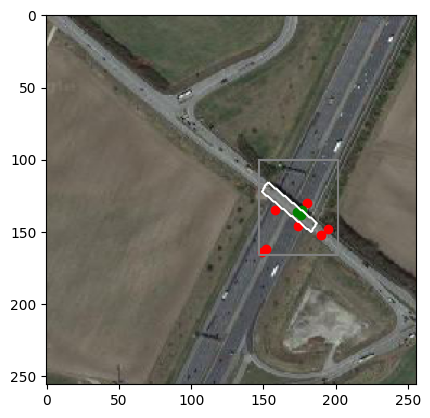

In [54]:
# Control visualization

bboxes, points, contours = mask_to_prompts(sample_bridge)
plt.imshow(sample_sat)

# Plot Foreground points in green, Background in red
for point_x, point_y, label in points[0]:
  plt.plot(point_x, point_y, marker='o', color="green" if label==1 else "red")

contour = contours[0]
plt.plot(contour[:,0,0], contour[:,0,1], color="white")

# Plot enlarged bounding box in gray
bbox_x, bbox_y, bbox_w, bbox_h = bboxes[0]
plt.plot([bbox_x, bbox_x+bbox_w, bbox_x+bbox_w, bbox_x, bbox_x], [bbox_y, bbox_y, bbox_y+bbox_h, bbox_y+bbox_h, bbox_y], color='gray')

### Step 4: Create Train and test folders

In [55]:
import os
from skimage.io import imsave
import tqdm

dataset_folder = 'drive/MyDrive/sam-bridges/datasets/munich_z16_v3'
train_folder = os.path.join(dataset_folder, 'train')
test_folder = os.path.join(dataset_folder, 'test')

os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

for tile_id, df in tqdm.tqdm(dataset.groupby('tile_id')):
  assert len(df) == 2, "Currently only supported for exactly one mask per satellite tile"
  split = df.split.iloc[0]
  mask = df[df['type']=='mask'].data.iloc[0]
  sat = df[df['type']=='sat'].data.iloc[0]
  bboxes, points, contours = mask_to_prompts(mask)
  datapoint_folder = os.path.join(dataset_folder, split, str(tile_id))
  os.makedirs(datapoint_folder, exist_ok=True)
  np.save(os.path.join(datapoint_folder, 'bboxes.npy'), np.array(bboxes))
  np.save(os.path.join(datapoint_folder, 'points.npy'), np.array(points))
  np.save(os.path.join(datapoint_folder, 'contours.npy'), np.array(contours))
  imsave(os.path.join(datapoint_folder, 'mask.png'), mask*255, check_contrast=False)
  imsave(os.path.join(datapoint_folder, 'sat.png'), sat)


  1%|          | 4/369 [00:00<00:54,  6.69it/s]<ipython-input-55-0e84fea7ae7e>:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save(os.path.join(datapoint_folder, 'contours.npy'), np.array(contours))
 95%|█████████▍| 349/369 [00:45<00:02,  7.11it/s]<ipython-input-43-268720769dcf>:40: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn("Didn't find a suitable foreground point!")
100%|██████████| 369/369 [00:48<00:00,  7.64it/s]


In [56]:
len(dataset)

738